# Mean-Variance Portfolios with Constraints


In [15]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [16]:
stock_df = pd.read_csv(
    R"D:\Study\Spring 25\Optimization Modeling in Finance\Data\returns_299.csv"
)

In [17]:
cov_panel = pd.read_parquet(
    R"D:\Study\Spring 25\Optimization Modeling in Finance\Project\ORIE-5370-Project-master\daily_covariance_matrix.parquet"
)

In [18]:
returns_df = stock_df.pivot(index="date", columns="PERMNO", values="RET")
returns_df = np.log(returns_df + 1)
returns_df.index = pd.to_datetime(returns_df.index)
monthly_returns_values = returns_df.resample("ME").sum()
month_end_dates = (
    returns_df.index.to_series().groupby(returns_df.index.to_period("M")).last()
)
monthly_returns_df = monthly_returns_values.copy()
monthly_returns_df.index = month_end_dates.values

# Step 2: Equal-weighted portfolio
equal_weights = (
    monthly_returns_df.notna()
    .astype(float)
    .div(monthly_returns_df.notna().sum(axis=1), axis=0)
)
equal_returns = (monthly_returns_df.shift(-1) * equal_weights).sum(axis=1)

In [19]:
dates = cov_panel.index.get_level_values(0)
dates = pd.to_datetime(dates)
month_end_dates = dates.to_series().groupby(dates.to_period("M")).last()

# 2. 过滤 cov_panel，只保留这些日期
cov_panel_monthly = cov_panel.loc[
    pd.to_datetime(cov_panel.index.get_level_values(0)).isin(month_end_dates.values)
]

In [20]:
cov_panel_monthly

10104     10107     10138     10145     10516  \
date       permno_i                                                     
2011-01-31 10104     0.050230  0.033779  0.042546  0.035227  0.047445   
           10107     0.033779  0.043995  0.039818  0.032969  0.044403   
           10138     0.042546  0.039818  0.069798  0.041526  0.055928   
           10145     0.035227  0.032969  0.041526  0.047851  0.046307   
           10516     0.047445  0.044403  0.055928  0.046307  0.086797   
...                       ...       ...       ...       ...       ...   
2022-12-30 91556     0.038133  0.050974  0.057735  0.036775  0.044454   
           92121     0.047439  0.063414  0.071826  0.045750  0.055304   
           92602     0.024908  0.033296  0.037712  0.024021  0.029037   
           92611     0.035834  0.047902  0.054256  0.034559  0.041775   
           92655     0.030129  0.040275  0.045617  0.029056  0.035124   

                        11308     11404     11600     11618     11674  ...  \
date       permno_i                                                    ...   
2011-01-31 10104     0.025479  0.016874  0.046436  0.045083  0.036000  ...   
           10107     0.023845  0.015793  0.043459  0.042192  0.033692  ...   
           10138     0.030035  0.019892  0.054739  0.053143  0.042437  ...   
           10145     0.024868  0.016470  0.045323  0.044002  0.035137  ...   
           10516     0.033493  0.022182  0.061041  0.059262  0.047323  ...   
...                       ...       ...       ...       ...       ...  ...   
2022-12-30 91556     0.026420  0.032812  0.057612  0.046404  0.031608  ...   
           92121     0.032868  0.040820  0.071673  0.057729  0.039322  ...   
           92602     0.017257  0.021432  0.037631  0.030310  0.020646  ...   
           92611     0.024828  0.030835  0.054140  0.043607  0.029703  ...   
           92655     0.020875  0.025925  0.045520  0.036664  0.024974  ...   

                        90808     90829     90880     90993     91233  \
date       permno_i                                                     
2011-01-31 10104     0.057843  0.071964  0.049139  0.044588  0.051709   
           10107     0.054134  0.067350  0.045988  0.041729  0.048394   
           10138     0.068185  0.084831  0.057925  0.052560  0.060955   
           10145     0.056456  0.070239  0.047961  0.043519  0.050470   
           10516     0.076036  0.094599  0.064594  0.058612  0.067973   
...                       ...       ...       ...       ...       ...   
2022-12-30 91556     0.072539  0.066713  0.043468  0.038741  0.046801   
           92121     0.090242  0.082994  0.054076  0.048196  0.058223   
           92602     0.047381  0.043576  0.028393  0.025305  0.030570   
           92611     0.068167  0.062692  0.040848  0.036407  0.043980   
           92655     0.057314  0.052711  0.034344  0.030610  0.036978   

                        91556     92121     92602     92611     92655  
date       permno_i                                                    
2011-01-31 10104     0.041710  0.050025  0.029427  0.047246  0.041708  
           10107     0.039036  0.046817  0.027540  0.044217  0.039034  
           10138     0.049168  0.058969  0.034688  0.055693  0.049166  
           10145     0.040710  0.048826  0.028721  0.046113  0.040708  
           10516     0.054829  0.065759  0.038682  0.062106  0.054827  
...                       ...       ...       ...       ...       ...  
2022-12-30 91556     0.096648  0.058095  0.030503  0.043884  0.036897  
           92121     0.058095  0.149579  0.037947  0.054594  0.045902  
           92602     0.030503  0.037947  0.041235  0.028664  0.024100  
           92611     0.043884  0.054594  0.028664  0.085350  0.034673  
           92655     0.036897  0.045902  0.024100  0.034673  0.060335  

[43056 rows x 299 columns]

In [21]:
import yfinance as yf

start, end = "2010-12-31", "2022-12-31"

idx = (
    yf.download("^GSPC", start=start, end=end, progress=False)
    .loc[:, ["Close"]]
    .rename(columns={"Close": "idx_price"})
)

idx["idx_ret"] = idx["idx_price"].pct_change()
idx["idx_ret"] = np.log(idx["idx_ret"] + 1)
idx = idx.reset_index()[["Date", "idx_ret"]].rename(columns={"Date": "date"})

idx.dropna(inplace=True)
idx.set_index("date", inplace=True)

In [22]:
idx

Price,idx_ret
Ticker,
date,
2011-01-03,0.011251
2011-01-04,-0.001314
2011-01-05,0.004995
2011-01-06,-0.002125
2011-01-07,-0.001846
...,...
2022-12-23,0.005851
2022-12-27,-0.004058


In [23]:
idx_monthly_returns_values = idx.resample("ME").sum()
idx_monthly_returns_df = idx_monthly_returns_values.copy()
idx_monthly_returns_df.index = month_end_dates.values
idx_monthly_returns_df.columns = idx_monthly_returns_df.columns.get_level_values(0)

In [24]:
butterflies = pd.read_parquet("butterfly.parquet").drop_duplicates()
butterflies.loc[:, "PERMNO"] = butterflies["PERMNO"].astype("int64")
butterflies_df = butterflies.pivot(index="date", columns="PERMNO", values="butterfly")

In [25]:
results = []

for delta in range(1, 11):
    meanvar_returns = []
    meanvar_weights = []

    for date, cov_df in cov_panel_monthly.groupby(level=0):
        cov_matrix = cov_df.droplevel(0)
        assets = cov_matrix.columns

        # Get valid returns
        month_returns = monthly_returns_df.shift(-1).loc[date, assets].dropna()
        valid_assets = month_returns.index
        cov_matrix = cov_matrix.loc[valid_assets, valid_assets]

        month_butterflies = butterflies_df.loc[date, assets]
        quantiles = pd.qcut(month_butterflies, 10, labels=False)

        idx_ret = idx_monthly_returns_df.loc[date, "idx_ret"]
        adjusted_returns = pd.Series(index=month_returns.index, dtype=float)
        adjusted_returns.loc[valid_assets] = idx_ret
        adjusted_returns.loc[quantiles == 0] = idx_ret * (1 + 0.1 * delta)
        adjusted_returns.loc[quantiles == 9] = idx_ret * (1 - 0.1 * delta)

        if len(valid_assets) < 2:
            meanvar_returns.append(np.nan)
            meanvar_weights.append(np.nan)
            continue

        # Setup optimization
        N = len(valid_assets)
        w = cp.Variable(N)

        # Ensure PSD matrix
        Sigma = cov_matrix.values
        eigvals, eigvecs = np.linalg.eigh(Sigma)
        eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
        Sigma_psd = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
        Sigma_cvx = cp.psd_wrap(Sigma_psd)

        mu = adjusted_returns.loc[valid_assets].values
        risk_aversion = 1

        # Build optimization problem directly with matrix (no cp.Parameter)
        objective = cp.Minimize(cp.quad_form(w, Sigma_cvx) - risk_aversion * mu @ w)
        constraints = [cp.sum(w) == 1, w >= 0]
        prob = cp.Problem(objective, constraints)

        try:
            prob.solve(solver=cp.SCS)
            weights = w.value
            port_return = weights @ month_returns.loc[valid_assets].values
            meanvar_returns.append(port_return)
            meanvar_weights.append(pd.Series(weights, index=valid_assets, name=date))
        except Exception as e:
            print(f"Optimization failed on {date}: {e}")
            meanvar_returns.append(np.nan)
            meanvar_weights.append(np.nan)
    
    equal_returns.name = 'equal_weighted'
    returns_combined = pd.concat([equal_returns[:-1], pd.Series(meanvar_returns[:-1], index=equal_returns[:-1].index, name='meanvar')], axis=1)

    equal_ret = returns_combined["equal_weighted"]
    meanvar_ret = returns_combined["meanvar"]

    def compute_metrics(ret_series):
        mean_monthly = ret_series.mean()
        std_monthly = ret_series.std()
        cum_return = ret_series.sum()
        ann_return = mean_monthly * 12
        ann_vol = std_monthly * np.sqrt(12)
        sharpe = ann_return / ann_vol
        return cum_return, ann_vol, sharpe
        
    mv_cum, mv_vol, mv_sharpe = compute_metrics(meanvar_ret)
    wins = (meanvar_ret > equal_ret)
    win_rate = wins.mean()

    weight_series = [w for w in meanvar_weights if isinstance(w, pd.Series)]
    dates = [w.name for w in weight_series]
    w_df = pd.DataFrame(weight_series, index=dates)

    turnover = w_df.diff().abs().sum(axis=1) / 2
    avg_monthly = turnover.mean()
    turnover_annual = avg_monthly * 12

    results.append({
        'delta_pct': delta * 10,            # 10%, 20%, ..., 100%
        'cum_return': mv_cum,
        'ann_vol':    mv_vol,
        'sharpe':     mv_sharpe,
        'win_rate':   win_rate,
        'turnover_annual': turnover_annual
    })

res_df = pd.DataFrame(results).set_index('delta_pct')
print("Butterfly", res_df)

Butterfly            cum_return   ann_vol    sharpe  win_rate  turnover_annual
delta_pct                                                           
10           1.294066  0.120289  0.902768  0.489510         8.411886
20           1.369591  0.120570  0.953229  0.482517         9.533379
30           1.560048  0.121045  1.081527  0.496503        10.155300
40           1.642593  0.121790  1.131779  0.510490        10.414006
50           1.679198  0.122410  1.151146  0.510490        10.564735
60           1.683273  0.122866  1.149656  0.510490        10.639851
70           1.675453  0.123141  1.141756  0.503497        10.657287
80           1.671525  0.123397  1.136721  0.510490        10.662678
90           1.671587  0.123626  1.134660  0.510490        10.668562
100          1.669946  0.123939  1.130683  0.510490        10.679912


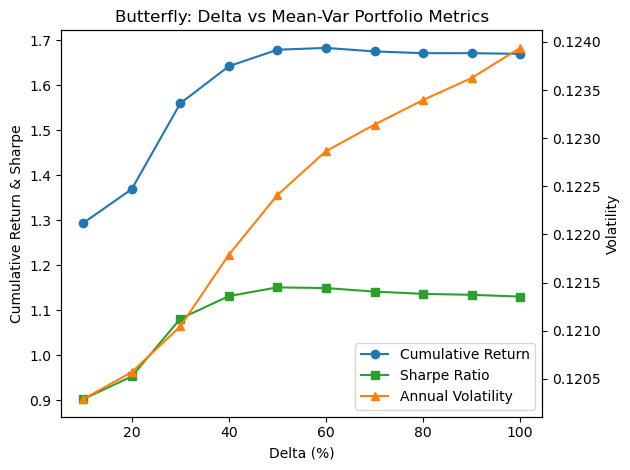

In [26]:
import matplotlib.pyplot as plt

# 假设 res_df 已经定义好，并且 index 是 delta_pct，包含 cum_return, ann_vol, sharpe 列

x = res_df.index  # [10,20,...,100]

fig, ax1 = plt.subplots()

# 左轴：累计收益 & 夏普
ax1.plot(x, res_df['cum_return'], label='Cumulative Return', color='tab:blue', marker='o')
ax1.plot(x, res_df['sharpe'],       label='Sharpe Ratio',      color='tab:green', marker='s')
ax1.set_xlabel('Delta (%)')
ax1.set_ylabel('Cumulative Return & Sharpe', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# 右轴：年化波动
ax2 = ax1.twinx()
ax2.plot(x, res_df['ann_vol'], label='Annual Volatility', color='tab:orange', marker='^')
ax2.set_ylabel('Volatility', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# 合并图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

plt.title("Butterfly: Delta vs Mean-Var Portfolio Metrics")
plt.tight_layout()
plt.show()

In [27]:
# equal_returns.name = 'equal_weighted'
# returns_combined = pd.concat([equal_returns[:-1], pd.Series(meanvar_returns[:-1], index=equal_returns[:-1].index, name='meanvar')], axis=1)
# print(returns_combined)

# equal_ret = returns_combined["equal_weighted"]
# meanvar_ret = returns_combined["meanvar"]


# def compute_metrics(ret_series):
#     mean_monthly = ret_series.mean()
#     std_monthly = ret_series.std()
#     cum_return = ret_series.sum()
#     ann_return = mean_monthly * 12
#     ann_vol = std_monthly * np.sqrt(12)
#     sharpe = ann_return / ann_vol
#     return cum_return, ann_vol, sharpe


# # Compute metrics for both portfolios
# eq_cum, eq_vol, eq_sharpe = compute_metrics(equal_ret)
# mv_cum, mv_vol, mv_sharpe = compute_metrics(meanvar_ret)

# # Build comparison DataFrame
# comparison_df = pd.DataFrame(
#     {
#         "Cumulative Return": [eq_cum, mv_cum],
#         "Annual Volatility": [eq_vol, mv_vol],
#         "Sharpe Ratio": [eq_sharpe, mv_sharpe],
#     },
#     index=["Equal Weighted", "Mean-Var"],
# )

# print(comparison_df)